<a href="https://colab.research.google.com/github/nurcse/MachineLearning/blob/master/Sakura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ID : A1811
Date : 08-03-2019

# Entrance Challenge: When Will the Sakura Bloom?

# 0. Basics of the Sakura Bloom-cycle

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    

### Problem 0-1
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2018 using the Japanese Meteorological Agency website (気象庁).

Dataset acquired from this site.

https://www.data.jma.go.jp/sakura/data/sakura003_06.html?fbclid=IwAR1dt4R5_rFXvYk38oVfvH0eD0HfeCbewEKtcTTnX-LZeA2QZx2jJRr-Rp4
***

In [1]:

from google.colab import files
uploaded = files.upload()


Saving sakura.csv to sakura.csv


In [0]:

import numpy as np

import pandas as pd
import io

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score


In [3]:
""" To load uploaded data into DataFrame
    make sure the filename matches the name of the uploaded file
"""

all_data_df = pd.read_csv(io.BytesIO(uploaded['sakura.csv']))
#print(test_df.head())
print('Columns :', all_data_df.columns)

print('number of columns :', len(all_data_df.columns), '\nnumber of rows :', len(all_data_df))

#all_data_df.head()

Columns : Index(['serial', 'year', 'month', 'day', 'local pressure', 'sea pressure',
       'total preci', 'hr1 preci', 'min10 preci', 'avg temp', 'max temp',
       'min temp', 'avg humid', 'min humid', 'sun hours', 'bloom'],
      dtype='object')
number of columns : 16 
number of rows : 20544


`a_df = df.loc[df['A']=='foo']` to get a DF depends on a single value conditon on a column

---


`b_df = df.loc[~df['column_name'].isin(some_values)]` to get a DF which doesn't match the condition, here condition is a List of values


In [4]:
"""
    Train DF and Test DF splitting
"""

test_df = all_data_df.loc[all_data_df.year.isin([1966, 1971, 1985, 1994, 2008])] # it returns a DataFrame on matched condition
#print(test_df.head())


# Get Train_DF
train_df = all_data_df.loc[~all_data_df.year.isin([1966, 1971, 1985, 1994, 2008])] # returns a DF which rows don't match these conditions
#print(train_df.head())
train_df.head()

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
0,0,1961,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,7.9,-3.9,41,15,8.6,0
1,1,1961,1,2,1020.2,1021.0,0.0,0.0,0.0,1.5,9.2,-3.3,51,26,8.7,0
2,2,1961,1,3,1021.3,1022.1,0.1,0.8,0.0,2.5,7.3,-2.4,58,37,5.4,0
3,3,1961,1,4,1004.6,1005.3,20.2,13.9,3.2,4.7,11.5,0.6,60,38,1.0,0
4,4,1961,1,5,1016.3,1017.0,0.0,0.0,0.0,3.8,7.7,1.4,33,19,8.3,0


In [5]:
# checking if sum of  trainDF and testDF have same rows equal to allDF
print(len(train_df))
print('sum of len:', len(train_df)+len(test_df))

18718
sum of len: 20544


In [6]:
train_years = np.unique(train_df.year)
train_years

#true_bloom_days_eYear = train_df.loc[train_df.bloom == 1] # this returns a DF on which rows match the condition
#true_bloom_days_eYear

array([1961, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

***
## 1. Prediction using the "600 Degree Rule"


For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

###Problem 1-1:
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

For getting index of a **row** based on a condition from a DF : `index = int(df[df['A']==5].index[0])`

In [0]:

feb_1_indexes = []
actual_bloomDay_indexes = []
c_sum_of_maxTemps = []
for i in range(len(train_years)):
  #print(train_years[i])
  
  feb_1_indexes.append(int(train_df[(train_df.month==2) & (train_df.day==1) & (train_df.year==train_years[i])].index[0]))
  
  actual_bloomDay_indexes.append(int(train_df[(train_df.bloom==1) & (train_df.year==train_years[i])].index[0]))
  
  c_sum_of_maxTemps.append(train_df.loc[feb_1_indexes[i]:actual_bloomDay_indexes[i], 'max temp'].sum(axis=0))
  
  print(train_years[i],'Feb 1 index :', feb_1_indexes[i], '\tbloom index :', actual_bloomDay_indexes[i], '\tcumulative sum of max temp. :', c_sum_of_maxTemps[i])
Tmean = np.mean(c_sum_of_maxTemps)
print('Tmean of cumulative temperature over the training years :', Tmean)


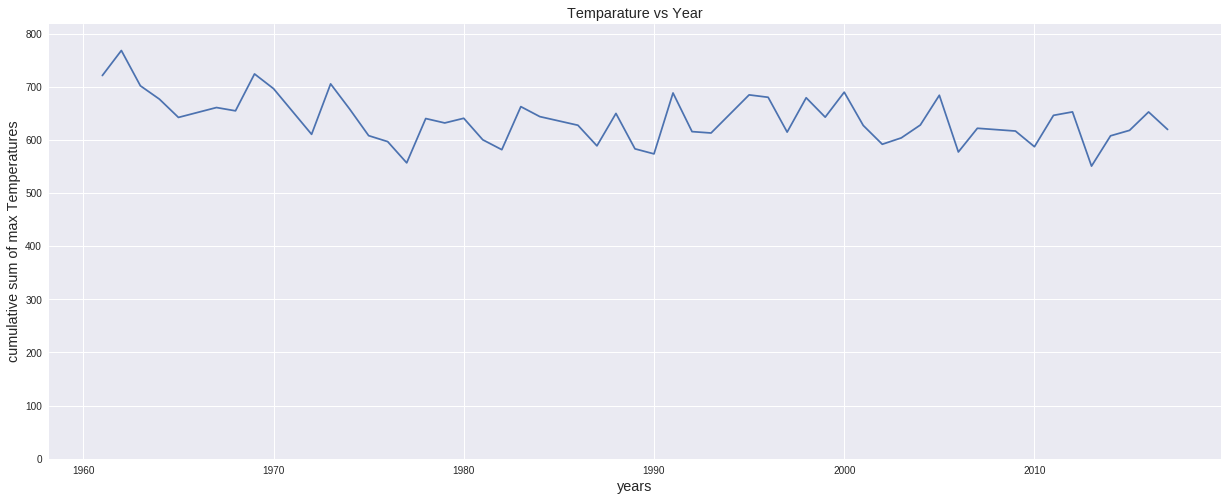

In [0]:

plt.plot(train_years, c_sum_of_maxTemps)
#plt.plot(train_years, c_sum_of_maxTemps, 'o', linestyle=':' ) #color='r'

plt.xlabel('years', fontsize='large')
plt.ylabel('cumulative sum of max Temperatures', fontsize='large')

plt.title("Temparature vs Year", fontsize='large')

#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(c_sum_of_maxTemps)+50)

plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


### Problem 1-2: 

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [8]:

test_years = np.unique(test_df.year)
test_years


array([1966, 1971, 1985, 1994, 2008])

In [0]:

true_bloom_days_in_test_years = test_df.loc[test_df.bloom == 1]
true_bloom_days_in_test_years


In [9]:
feb_1_indexes_test = []
actual_bloomDay_indexes_test = []
c_sum_of_maxTemps_test = []
predicted_sum_of_maxTemps = []

number_of_days_Tmean = []
number_of_days_actual = []
number_of_days_600 = []

print('Tmean :', Tmean,'\n')

for i in range(len(test_years)):
  #print(train_years[i])
  
  feb_1_indexes_test.append(int(test_df[(test_df.month==2) & (test_df.day==1) & (test_df.year==test_years[i])].index[0]))
  
  actual_bloomDay_indexes_test.append(int(test_df[(test_df.bloom==1) & (test_df.year==test_years[i])].index[0]))
  
  c_sum_of_maxTemps_test.append(test_df.loc[feb_1_indexes_test[i]:actual_bloomDay_indexes_test[i], 'max temp'].sum(axis=0))
  
  predicted_temp_sum = 0
  index = feb_1_indexes_test[i]
  numberOfDays = 0
  flag = True
  
  while(predicted_temp_sum < Tmean):
    predicted_temp_sum += test_df.loc[index, 'max temp']
    index += 1
    numberOfDays += 1
    
    if(predicted_temp_sum >= 600 and flag):
      number_of_days_600.append(numberOfDays)
      flag = False
      
  number_of_days_Tmean.append(numberOfDays)
  number_of_days_actual.append((actual_bloomDay_indexes_test[i] - feb_1_indexes_test[i] + 1))
  predicted_sum_of_maxTemps.append(predicted_temp_sum)
  
  #print(test_years[i],'Feb 1 index :', feb_1_indexes_test[i], '\tbloom index :', actual_bloomDay_indexes_test[i], '\tactual cumulative sum :', c_sum_of_maxTemps_test[i]
  #     ,'\tcumulative sum of prediction :', predicted_sum_of_maxTemps[i])
  print('==> actually required days :', number_of_days_actual[i], '\tTmean used predicted required days :', number_of_days_Tmean[i], '\t600* used predicted required days :'
        , number_of_days_600[i],'\n')
  
print('Tmean of cumulative temperature(feb1 - actual bloom day) over the test years :', np.mean(c_sum_of_maxTemps_test))
  

Tmean : 638.3557692307693 

==> actually required days : 48 	Tmean used predicted required days : 51 	600* used predicted required days : 48 

==> actually required days : 58 	Tmean used predicted required days : 57 	600* used predicted required days : 55 

==> actually required days : 62 	Tmean used predicted required days : 60 	600* used predicted required days : 57 

==> actually required days : 59 	Tmean used predicted required days : 59 	600* used predicted required days : 56 

==> actually required days : 51 	Tmean used predicted required days : 54 	600* used predicted required days : 52 

Tmean of cumulative temperature(feb1 - actual bloom day) over the test years : 640.4200000000001


RMSE for Tmean : 2.1447610589527217
RMSE for 600 Degree C : 2.9664793948382653

R^2 Score for Tmean : 0.8323615160349854
R^2 Score for 600 Degree C : 0.6793002915451896


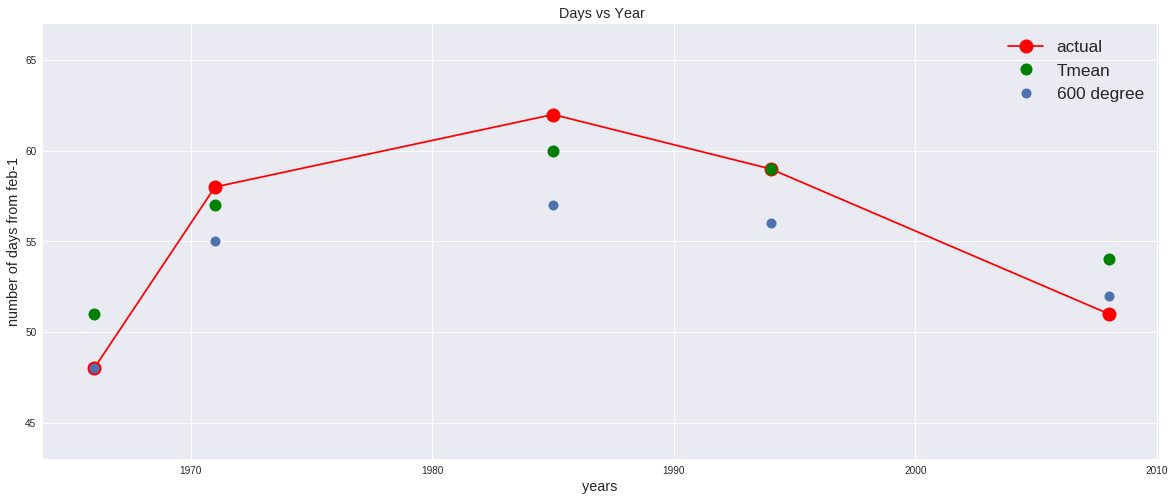

In [0]:

rmse_Tmean = np.sqrt(np.mean((np.array(number_of_days_actual) - np.array(number_of_days_Tmean))**2))
print('RMSE for Tmean :', rmse_Tmean)

rmse_600 = np.sqrt(np.mean((np.array(number_of_days_actual) - np.array(number_of_days_600))**2))
print('RMSE for 600 Degree C :', rmse_600)

print('\nR^2 Score for Tmean :', r2_score(number_of_days_actual, number_of_days_Tmean))
print('R^2 Score for 600 Degree C :', r2_score(number_of_days_actual, number_of_days_600))

plt.plot(test_years, number_of_days_actual, 'o', markersize=14, color='r', linestyle='-')
plt.plot(test_years, number_of_days_Tmean, 'o', markersize=12, color='g')
plt.plot(test_years, number_of_days_600, 'o', markersize=10)
plt.legend(('actual', 'Tmean', '600 degree'), loc='upper right', shadow=True, fontsize='x-large')

plt.xlabel('years ', fontsize='large')
plt.ylabel('number of days from feb-1', fontsize='large')
plt.title("Days vs Year", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(np.min(number_of_days_actual)-5, np.max(number_of_days_actual)+5)
plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


### Evaluation (Comment on $R^2$  score)
- We saw that RMSE score is greater when we used 600 degree C as threshold than Tmean. 
<br>
- And also $R^2$ score score is smaller when we used 600 degree C as threshold than Tmean. <br> 
- So we can  say that **Tmean is a better model than 600 degree C**. model.

***
## 2. Linear Regression Model: Transform to Standard Temperature

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.

#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>

We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>

In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.

### Problem 2-1:
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [11]:

all_years = np.unique(all_data_df.year)

PHI_TOKYO = 35 + (40/60)
print('phi value of TOKYO :', PHI_TOKYO)
L_TOKYO = 4 # L = L is the distance from the nearest coastline

jan_1_indexes_years = []
jan_1_indexes_years_dic = {}

mar_31_indexes_years = []
mar_31_indexes_years_dic = {}
avg_temp_first3months_each_years = []

Dj_each_years = []
Dj_train_years = []
Dj_test_years = []

for i in range(len(all_years)):
  jan_1_indexes_years.append(int(all_data_df[(all_data_df.month==1) & (all_data_df.day==1) & (all_data_df.year==all_years[i])].index[0]))
  jan_1_indexes_years_dic[all_years[i]] = int(all_data_df[(all_data_df.month==1) & (all_data_df.day==1) & (all_data_df.year==all_years[i])].index[0])
  
  mar_31_indexes_years.append(int(all_data_df[(all_data_df.month==3) & (all_data_df.day==31) & (all_data_df.year==all_years[i])].index[0]))
  mar_31_indexes_years_dic[all_years[i]] = int(all_data_df[(all_data_df.month==3) & (all_data_df.day==31) & (all_data_df.year==all_years[i])].index[0])
  
  avg_temp_first3months_each_years.append(all_data_df.loc[jan_1_indexes_years[i] : mar_31_indexes_years[i], 'avg temp'].mean(axis=0))
  
  # Dj = 136.75 − 7.689ϕ + 0.133ϕ2 − 1.307lnL + 0.144TF + 0.285T2F
  Dj_each_years.append(136.75 - (7.689*PHI_TOKYO) + (0.133*PHI_TOKYO**2) - (1.307*np.log(L_TOKYO)) + (0.144*avg_temp_first3months_each_years[i]) + 
                      (0.285*avg_temp_first3months_each_years[i]**2))
  
  if(all_years[i] in test_years):
    Dj_test_years.append(Dj_each_years[i])
  else:
    Dj_train_years.append(Dj_each_years[i])


print('avg. temp of first 3 months :', avg_temp_first3months_each_years)
print('Dj value of all years :', Dj_each_years)


phi value of TOKYO : 35.666666666666664
avg. temp of first 3 months : [5.471111111111112, 6.254444444444444, 5.2155555555555555, 5.752747252747253, 5.354444444444446, 7.13888888888889, 6.334444444444444, 6.740659340659338, 6.438888888888887, 5.335555555555556, 6.445555555555556, 7.164835164835163, 6.985555555555558, 5.601111111111112, 5.90888888888889, 7.037362637362637, 5.918888888888888, 6.23, 8.307777777777776, 6.364835164835164, 6.262222222222222, 7.082222222222221, 6.983333333333333, 4.246153846153847, 6.110000000000001, 5.548888888888889, 7.328888888888888, 7.035164835164836, 8.413333333333336, 7.797777777777776, 7.487777777777776, 7.810989010989011, 7.519999999999998, 6.727777777777776, 7.2411111111111115, 7.093406593406592, 8.153333333333332, 7.514444444444448, 7.834444444444443, 7.684615384615386, 7.132222222222222, 9.234444444444446, 6.87111111111111, 8.218681318681316, 7.112222222222224, 7.205555555555556, 9.05, 7.4021978021978025, 8.193333333333335, 7.574444444444443, 6.704

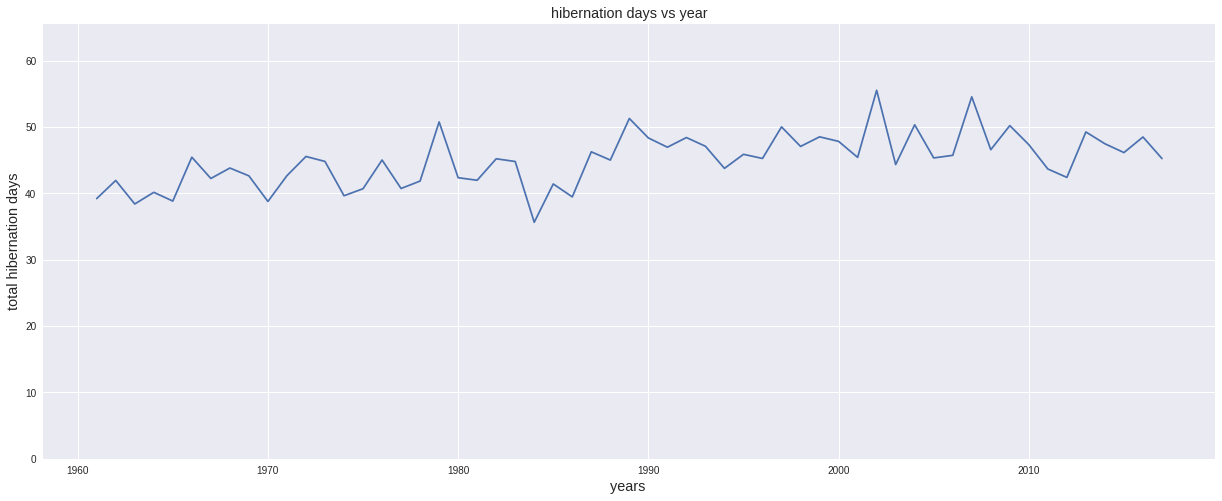

In [0]:

plt.plot(all_years, Dj_each_years)

plt.xlabel('years ', fontsize='large')
plt.ylabel('total hibernation days', fontsize='large')

plt.title("hibernation days vs year", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(Dj_each_years)+10)

plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


### Problem 2-2:
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 

In [14]:

Dj_train_years_indexes = []
for i in range(len(train_years)):
  Dj_train_years[i] = round(Dj_train_years[i])
  Dj_train_years_indexes.append( int(jan_1_indexes_years_dic[train_years[i]] + Dj_train_years[i] - 1) )
  
print('indexes of Dj in train years :', Dj_train_years_indexes)


indexes of Dj in train years : [38, 406, 767, 1134, 1499, 2232, 2599, 2964, 3325, 4062, 4427, 4787, 5153, 5522, 5884, 6250, 6624, 6980, 7346, 7714, 8079, 8435, 9169, 9541, 9905, 10277, 10639, 11003, 11369, 11734, 12463, 12827, 13198, 13560, 13927, 14291, 14654, 15030, 15383, 15754, 16115, 16481, 16855, 17581, 17943, 18305, 18668, 19041, 19404, 19768, 20135, 20498]


In [15]:
DTSj_each_Ea_dic = {}
DTSj_mean_train = []

Ts = 290.15
R = 8.314

for Ea in range(5, 41):
  DTSj_each_year = []
  for i in range(len(train_years)):
    ts = 0
    for j in range(Dj_train_years_indexes[i] , actual_bloomDay_indexes[i]+1):
      Tij = train_df.loc[j, 'avg temp'] + 273.15
      ts += np.exp((Ea*4.184*1000*(Tij-Ts)) / (R * Tij * Ts))
    DTSj_each_year.append(ts)
  DTSj_mean_train.append(np.mean(DTSj_each_year))
  DTSj_each_Ea_dic[Ea] = DTSj_each_year
  
DTSj_each_Ea_dic
print('DTSj_mean over train for every Ea :', DTSj_mean_train)

DTSj_mean over train for every Ea : [31.89948520675808, 30.200755693591102, 28.60505732345086, 27.105658587998736, 25.69629252980513, 24.37112325700012, 23.124714961251488, 21.952003245917986, 20.848268586550777, 19.809111759994924, 18.830431091278292, 17.908401379362793, 17.03945437375904, 16.220260684050405, 15.447713013607816, 14.718910617270657, 14.031144890580995, 13.381886005346226, 12.768770512917822, 12.189589842660617, 11.642279628688973, 11.12490980310392, 10.635675398714552, 10.172888008601044, 9.734967853905468, 9.320436414948857, 8.927909584193506, 8.556091302722063, 8.203767644811283, 7.869801317857723, 7.553126547383671, 7.252744319130586, 6.967717952349905, 6.697168980340852, 6.44027331607519, 6.196257682401297]


Ea : [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


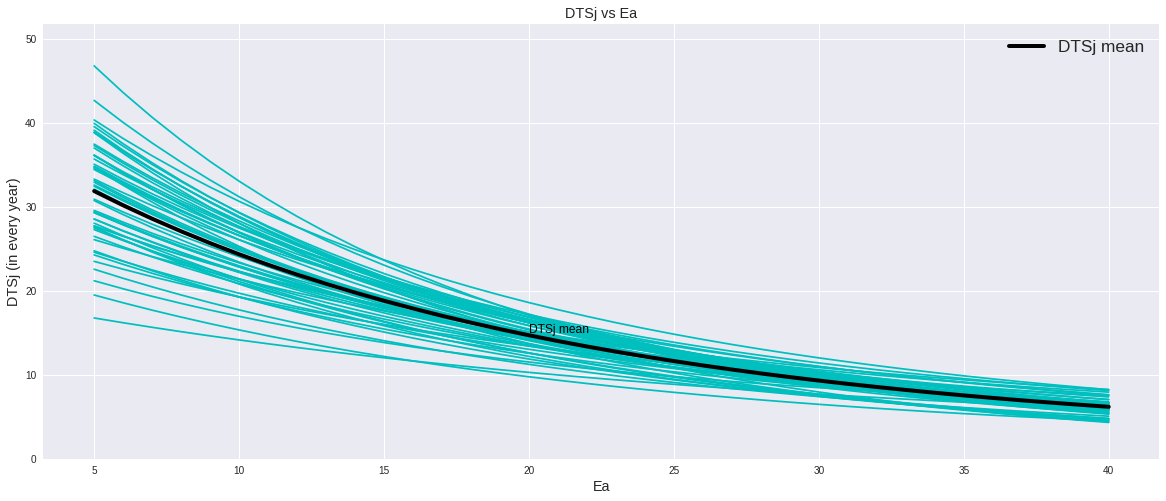

In [0]:

DTSj_year_Ea = []
Ea = [i for i in range(5,41)]
print('Ea :', Ea)

for i in range(len(train_years)):
  DTSj_year = []
  for val in Ea:
    DTSj_year.append(DTSj_each_Ea_dic[val][i])
  DTSj_year_Ea.append(DTSj_year)
  
  plt.plot(Ea, DTSj_year, color='c')
#print(DTSj_year_Ea) 

plt.plot(Ea, DTSj_mean_train, color='k', label='DTSj mean', linewidth=4)

plt.legend(loc='best', shadow=True, fontsize='x-large')
plt.text(20, 15, 'DTSj mean', color='k')

plt.xlabel('Ea', fontsize='large')
plt.ylabel('DTSj (in every year)', fontsize='large')

plt.title("DTSj vs Ea", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(DTSj_year_Ea)+5)

plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


### Problem 2-3:
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

In [0]:

R2_scores_train = []
MSE_scores_train = []

number_of_days_DTSmean_forEa_train = []

Ea = [i for i in range(5,41)]
Ts = 290.15
R = 8.314

for j in range(len(Ea)):
  number_of_days_DTSmean_train = []
  number_of_days_actual_train = []
  print('values for when Ea :', Ea[j], '\tDTSmean :', DTSj_mean_train[j])
  
  for i in range(len(train_years)):
    ts_train = 0
    number_of_days = 0
    Dj_train_index = Dj_train_years_indexes[i]

    while(ts_train <= DTSj_mean_train[j]):
      Tij_train = train_df.loc[Dj_train_index, 'avg temp'] + 273.15
      ts_train += np.exp((Ea[j]*4.184*1000*(Tij_train - Ts)) / (R * Tij_train * Ts))
      number_of_days += 1
      Dj_train_index += 1
      if(Dj_train_index >= 20544):
        break
      
    number_of_days_DTSmean_train.append(number_of_days)
    number_of_days_actual_train.append((actual_bloomDay_indexes[i] - Dj_train_years_indexes[i] + 1))
    
    print('==> actually required days :', number_of_days_actual_train[i], '\tpredicted DTSmean required days :', number_of_days_DTSmean_train[i])
    
  mse_DTSmean = np.mean((np.array(number_of_days_actual_train) - np.array(number_of_days_DTSmean_train))**2)
  MSE_scores_train.append(mse_DTSmean)
  
  number_of_days_DTSmean_forEa_train.append(number_of_days_DTSmean_train)
  
  R2_scores_train.append(r2_score(number_of_days_actual_train, number_of_days_DTSmean_train))
  
  print('for Ea :', Ea[j], 'MSE is :', mse_DTSmean, '\tR^2 :', R2_scores_train[j])


In [32]:

print('index of minimum MSE error :', np.argmin(MSE_scores_train))
print('Training minimum MSE error :', MSE_scores_train[np.argmin(MSE_scores_train)], '\nTraining r2 score(when error lowest) :', R2_scores_train[np.argmin(MSE_scores_train)])
print('DTSmean for which MSE was lowest :', DTSj_mean_train[np.argmin(MSE_scores_train)])
print('Optimal E* :', Ea[np.argmin(MSE_scores_train)])
#minimum_MSE_line_values = [MSE_scores_train[np.argmin(MSE_scores_train)] for i in range(5,41)]
minimum_MSE_line_values = [MSE_scores_train[np.argmin(MSE_scores_train)]]*36


index of minimum MSE error : 23
Training minimum MSE error : 9.365384615384615 
Training r2 score(when error lowest) : 0.8933110889228734
DTSmean for which MSE was lowest : 10.172888008601044
Optimal E* : 28


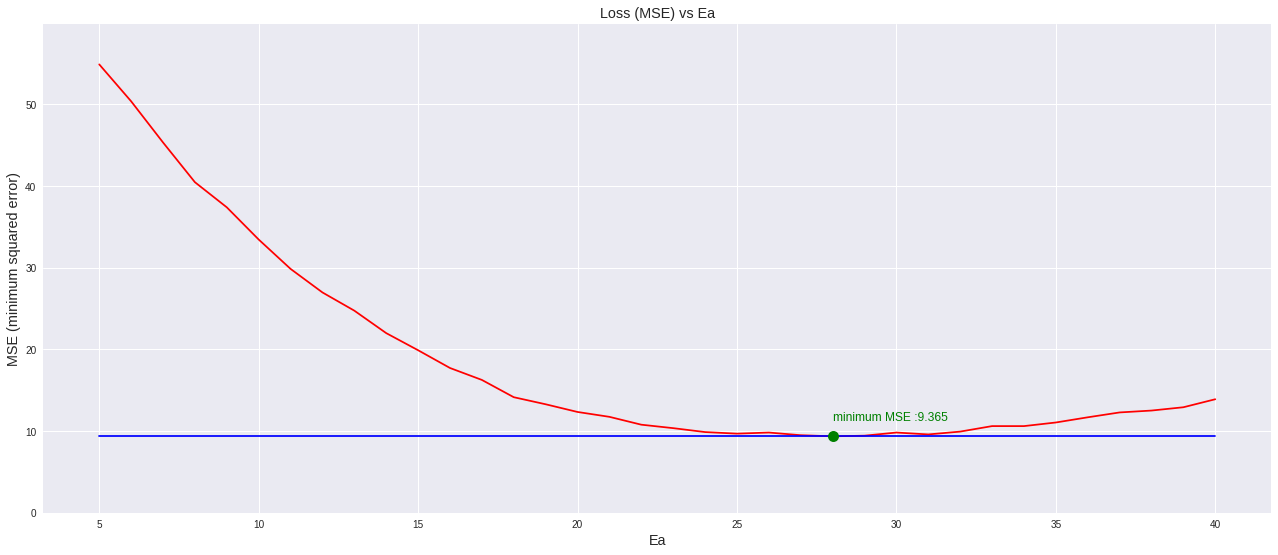

In [40]:
plt.plot(Ea, MSE_scores_train, color='r')
plt.plot(Ea, minimum_MSE_line_values, color='b')

plt.plot(Ea[np.argmin(MSE_scores_train)], MSE_scores_train[np.argmin(MSE_scores_train)], 'o', color='g', markersize=11)
plt.text(Ea[np.argmin(MSE_scores_train)], MSE_scores_train[np.argmin(MSE_scores_train)]+2, 'minimum MSE :9.365', color='g')

plt.xlabel('Ea', fontsize='large')
plt.ylabel('MSE (minimum squared error)', fontsize='large')

plt.title("Loss (MSE) vs Ea", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(MSE_scores_train)+5)

plt.rcParams['figure.figsize'] = [22, 9]
plt.show()

### Problem 2-4:

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [19]:

Dj_test_years_indexes = []
for i in range(len(test_years)):
  Dj_test_years[i] = round(Dj_test_years[i])
  Dj_test_years_indexes.append( int(jan_1_indexes_years_dic[test_years[i]] + Dj_test_years[i] - 1) )

Dj_test_years_indexes


[1870, 3694, 8806, 12096, 17212]

In [20]:

Ea_star = Ea[np.argmin(MSE_scores_train)]
Ts = 290.15
R = 8.314

number_of_days_DTSmean_test = []
number_of_days_actual_test = []

for i in range(len(test_years)):
  ts_test = 0
  number_of_days = 0
  Dj_test_index = Dj_test_years_indexes[i]

  while(ts_test <= DTSj_mean_train[np.argmin(MSE_scores_train)]):
    Tij_test = test_df.loc[Dj_test_index, 'avg temp'] + 273.15
    ts_test += np.exp((Ea_star*4.184*1000*(Tij_test - Ts)) / (R * Tij_test * Ts))
    number_of_days += 1
    Dj_test_index += 1
    
  number_of_days_DTSmean_test.append(number_of_days)
  number_of_days_actual_test.append((actual_bloomDay_indexes_test[i] - Dj_test_years_indexes[i] + 1))

  print('==> actually required days :', number_of_days_actual_test[i], '\tpredicted DTSmean required days :', number_of_days_DTSmean_test[i])
  
R2_scores_test = r2_score(number_of_days_actual_test, number_of_days_DTSmean_test)
  
print('for Ea :', Ea_star, '\tR^2 :', R2_scores_train[j])


==> actually required days : 35 	predicted DTSmean required days : 35
==> actually required days : 47 	predicted DTSmean required days : 46
==> actually required days : 53 	predicted DTSmean required days : 51
==> actually required days : 47 	predicted DTSmean required days : 48
==> actually required days : 36 	predicted DTSmean required days : 37
for Ea : 28 	R^2 : 0.8416096864296457


### Problem 2-5:
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1.According to the mentioned model and datasets, there is an assumption that the average temperature of a single day is sustained throughout the day. This is not the case in real life as the temperature can flactuate even from hour to hour. So if the fluctuations of the temperature could be added, the accuracy and could possibly be improved.



2.There are different species of cherry trees from the Prunus genus. Different species of trees might have different type if implecations to different changes of variables. We did not take that into account. If we can take those things into consideration, accuracy might be improved.


3.In the mentioned model didn't consider the sun hours in a day, as the chemical reaction depends on sunlight, so if we could add the duration of sun light in a particular day, the accuracy might improve. And more precisely as temperature fluctuate if the different temperatures with different duration could be added, accuracy might improve.


4.Local pressure, himidity also may have effect on chemical reaction, so these parameters inclusion also might improve the accuracy.


***
## 3. Predicting Bloom-date via Neural Network 

### Problem 3-1: 

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

***
### ANN Approach-1:
In this approach my input is two feature and output is a single regression value. This model may called be a regression model. The two input feature are preprocessed from actual Data. I used calculated $Dj$ and number of days to reach $DTSmean$ from $Dj$ for a particular year as feature and number of days from $Dj$ to actual bloom day as Target.
<br>
hyper parameters are :
- 2 input nodes
- 1 hidden layer with 8 nodes
- AdamOptimizer as cost function
- learning rate 0.15
- 500 epochs and full dataset in every epoch
<br> 

after 500 epoch the network gave 0.975328947368421 as $R^2$ value on test data.

In [0]:

X_train = []
for i in range(len(number_of_days_actual_train)):
  l = [Dj_train_years[i], number_of_days_DTSmean_forEa_train[np.argmin(MSE_scores_train)][i] ]
  X_train.append(l)
Y_train = number_of_days_actual_train

Y_train = np.array(Y_train).reshape((52, 1))

print(len(Y_train), ' ', len(X_train), ' shape x then y', np.shape(X_train), ' ', np.shape(Y_train) )


52   52  shape x then y (52, 2)   (52, 1)


In [0]:

X_test = []
for i in range(len(number_of_days_actual_test)):
  l = [ Dj_test_years[i], number_of_days_DTSmean_test[i] ]
  X_test.append(l)
Y_test = number_of_days_actual_test


In [0]:

import tensorflow as tf

input_num_units = 2
hidden_num_units_1 = 8
output_num_units = 1

epochs = 500

loss_list = []

# define placeholders
x_train = tf.placeholder(tf.float32, [None, input_num_units])
y_train = tf.placeholder(tf.float32, [None, output_num_units])

### define weights and biases of the neural network  
weights = {
    'hidden_1': tf.Variable(tf.truncated_normal ([input_num_units, hidden_num_units_1])),
    'output': tf.Variable(tf.truncated_normal ([hidden_num_units_1, output_num_units]))
}

biases = {
    'hidden_1': tf.Variable(tf.truncated_normal ([hidden_num_units_1])),
    'output': tf.Variable(tf.truncated_normal ([output_num_units]))
}

#Now create our neural networks computational graph
hidden_layer_1 = tf.add(tf.matmul(x_train, weights['hidden_1']), biases['hidden_1'])
hidden_layer_1 = tf.nn.relu(hidden_layer_1)

output_layer = tf.add(tf.matmul(hidden_layer_1, weights['output']), biases['output'])

#Also, we need to define cost of our neural network
cost = tf.reduce_mean((Y_train - output_layer)**2)

optimizer = tf.train.AdamOptimizer(learning_rate=0.15) #AdamOptimizer  GradientDescentOptimizer  AdagradOptimizer
train = optimizer.minimize(cost)

init = tf.global_variables_initializer()

ses = tf.Session()
ses.run(init)

for i in range(epochs):
  _,loss_value = ses.run((train, cost), feed_dict = {x_train: X_train, y_train: Y_train})
  
  loss_list.append(np.sqrt(loss_value))
  print('epoch : #', i+1, 'cost(rmse) :', np.sqrt(loss_value))
  
output_value = ses.run(output_layer, feed_dict = {x_train: X_test})

ses.close()


epoch : # 1 cost(rmse) : 27.17802
epoch : # 2 cost(rmse) : 11.764065
epoch : # 3 cost(rmse) : 22.827122
epoch : # 4 cost(rmse) : 23.57268
epoch : # 5 cost(rmse) : 18.981915
epoch : # 6 cost(rmse) : 10.458246
epoch : # 7 cost(rmse) : 3.7253134
epoch : # 8 cost(rmse) : 12.955253
epoch : # 9 cost(rmse) : 16.99046
epoch : # 10 cost(rmse) : 13.480637
epoch : # 11 cost(rmse) : 6.3581142
epoch : # 12 cost(rmse) : 4.3601546
epoch : # 13 cost(rmse) : 9.178593
epoch : # 14 cost(rmse) : 12.035448
epoch : # 15 cost(rmse) : 12.310645
epoch : # 16 cost(rmse) : 10.289333
epoch : # 17 cost(rmse) : 6.5606756
epoch : # 18 cost(rmse) : 3.3664296
epoch : # 19 cost(rmse) : 5.9375696
epoch : # 20 cost(rmse) : 8.948829
epoch : # 21 cost(rmse) : 9.251512
epoch : # 22 cost(rmse) : 6.903094
epoch : # 23 cost(rmse) : 3.7508566
epoch : # 24 cost(rmse) : 3.8224323
epoch : # 25 cost(rmse) : 6.0629907
epoch : # 26 cost(rmse) : 7.2743726
epoch : # 27 cost(rmse) : 6.9476395
epoch : # 28 cost(rmse) : 5.3167295
epoch : 

In [0]:
for i in range(len(output_value)):
  output_value[i] = output_value[i].round()

print('actual days :', number_of_days_actual_test, '\nann days :', output_value)

print('r2 score :', r2_score(number_of_days_actual_test, output_value))

actual days : [35, 47, 53, 47, 36] 
ann days : [[34.]
 [46.]
 [51.]
 [47.]
 [36.]]
r2 score : 0.975328947368421


***
### ANN Approach-2:
In this approach my input is seven features and output is a single regression value. This model may called be a regression model. The seven input features are average of max temperature, min temperature, avg temperature, min humidity, avg humidity and sum of sun hours of first three years for a particular year. 
<br>
hyper parameters are :
- 7 input nodes
- 1 hidden layer with 15 nodes
- AdamOptimizer as cost function
- learning rate 0.15
- 1000 epochs and full dataset in every epoch
<br> 

after 1000 epoch the network gave 0.7245065789473684 as $R^2$ value on test data.

In [42]:
"""
    Preparation of Training Data for NN-2
"""

X_train_2 = [] 

for i in range(len(train_years)):
  l = []
  l.append(Dj_train_years[i])
  l.append( train_df.loc[Dj_train_years_indexes[i] : mar_31_indexes_years_dic[train_years[i]], 'max temp'].mean(axis=0) )
  l.append( train_df.loc[Dj_train_years_indexes[i] : mar_31_indexes_years_dic[train_years[i]], 'min temp'].mean(axis=0) )
  l.append( train_df.loc[Dj_train_years_indexes[i] : mar_31_indexes_years_dic[train_years[i]], 'avg temp'].mean(axis=0) )
  l.append( train_df.loc[Dj_train_years_indexes[i] : mar_31_indexes_years_dic[train_years[i]], 'sun hours'].sum(axis=0) )
  l.append( train_df.loc[Dj_train_years_indexes[i] : mar_31_indexes_years_dic[train_years[i]], 'avg humid'].mean(axis=0) )
  l.append( train_df.loc[Dj_train_years_indexes[i] : mar_31_indexes_years_dic[train_years[i]], 'min humid'].mean(axis=0) )
  #l.append( train_df.loc[Dj_train_years_indexes[i] : mar_31_indexes_years_dic[train_years[i]], 'local pressure'].mean(axis=0) )
  
  X_train_2.append(l)
  
Y_train_2 = number_of_days_actual_train

Y_train_2 = np.array(Y_train_2).reshape((52, 1))

print(len(Y_train_2), ' ', len(X_train_2), ' shape x then y', np.shape(X_train_2), ' ', np.shape(Y_train_2) )
print(X_train_2[0])


52   52  shape x then y (52, 7)   (52, 1)
[39.0, 12.182692307692305, 2.1999999999999997, 6.767307692307691, 336.8, 55.28846153846154, 35.71153846153846]


In [0]:
"""
    Preparation Test Data for Testing NN-2
"""
X_test_2 = []
  
for i in range(len(test_years)):
  l = []
  l.append(Dj_train_years[i])
  l.append( test_df.loc[Dj_test_years_indexes[i] : mar_31_indexes_years_dic[test_years[i]], 'max temp'].mean(axis=0) )
  l.append( test_df.loc[Dj_test_years_indexes[i] : mar_31_indexes_years_dic[test_years[i]], 'min temp'].mean(axis=0) )
  l.append( test_df.loc[Dj_test_years_indexes[i] : mar_31_indexes_years_dic[test_years[i]], 'avg temp'].mean(axis=0) )
  l.append( test_df.loc[Dj_test_years_indexes[i] : mar_31_indexes_years_dic[test_years[i]], 'sun hours'].sum(axis=0) )
  l.append( test_df.loc[Dj_test_years_indexes[i] : mar_31_indexes_years_dic[test_years[i]], 'avg humid'].mean(axis=0) )
  l.append( test_df.loc[Dj_test_years_indexes[i] : mar_31_indexes_years_dic[test_years[i]], 'min humid'].mean(axis=0) )
  #l.append( test_df.loc[Dj_test_years_indexes[i] : mar_31_indexes_years_dic[test_years[i]], 'local pressure'].mean(axis=0) )
  
  X_test_2.append(l)
  
Y_test_2 = number_of_days_actual_test

In [56]:
import tensorflow as tf

input_num_units = 7
hidden_num_units_1 = 15
output_num_units = 1

epochs = 1000

loss_list = []

# define placeholders
x_train = tf.placeholder(tf.float32, [None, input_num_units])
y_train = tf.placeholder(tf.float32, [None, output_num_units])

### define weights and biases of the neural network  
weights = {
    'hidden_1': tf.Variable(tf.truncated_normal ([input_num_units, hidden_num_units_1])),
    'output': tf.Variable(tf.truncated_normal ([hidden_num_units_1, output_num_units]))
}

biases = {
    'hidden_1': tf.Variable(tf.truncated_normal ([hidden_num_units_1])),
    'output': tf.Variable(tf.truncated_normal ([output_num_units]))
}

#Now create our neural networks computational graph
hidden_layer_1 = tf.add(tf.matmul(x_train, weights['hidden_1']), biases['hidden_1'])
hidden_layer_1 = tf.nn.relu(hidden_layer_1)

output_layer = tf.add(tf.matmul(hidden_layer_1, weights['output']), biases['output'])

#Also, we need to define cost of our neural network
cost = tf.reduce_mean((Y_train_2 - output_layer)**2)

optimizer = tf.train.AdamOptimizer(learning_rate=0.16) #AdamOptimizer  GradientDescentOptimizer  AdagradOptimizer
train = optimizer.minimize(cost)

init = tf.global_variables_initializer()

ses = tf.Session()
ses.run(init)

for i in range(epochs):
  _,loss_value = ses.run((train, cost), feed_dict = {x_train: X_train_2, y_train: Y_train_2})
  #if((i+1)%25 == 0):
  loss_list.append(np.sqrt(loss_value))
  print('epoch : #', i+1, 'cost(rmse) :', np.sqrt(loss_value))
  
output_value = ses.run(output_layer, feed_dict = {x_train: X_test_2})

ses.close()

epoch : # 1 cost(rmse) : 206.11555
epoch : # 2 cost(rmse) : 196.45676
epoch : # 3 cost(rmse) : 200.97997
epoch : # 4 cost(rmse) : 78.89783
epoch : # 5 cost(rmse) : 71.03078
epoch : # 6 cost(rmse) : 150.08089
epoch : # 7 cost(rmse) : 138.03917
epoch : # 8 cost(rmse) : 69.724655
epoch : # 9 cost(rmse) : 23.817715
epoch : # 10 cost(rmse) : 81.54949
epoch : # 11 cost(rmse) : 108.82583
epoch : # 12 cost(rmse) : 100.28985
epoch : # 13 cost(rmse) : 65.176895
epoch : # 14 cost(rmse) : 20.082226
epoch : # 15 cost(rmse) : 36.86698
epoch : # 16 cost(rmse) : 68.70185
epoch : # 17 cost(rmse) : 78.29486
epoch : # 18 cost(rmse) : 65.122604
epoch : # 19 cost(rmse) : 36.853806
epoch : # 20 cost(rmse) : 11.518813
epoch : # 21 cost(rmse) : 31.887201
epoch : # 22 cost(rmse) : 50.429165
epoch : # 23 cost(rmse) : 55.81692
epoch : # 24 cost(rmse) : 48.20718
epoch : # 25 cost(rmse) : 30.99031
epoch : # 26 cost(rmse) : 11.674663
epoch : # 27 cost(rmse) : 18.410608
epoch : # 28 cost(rmse) : 33.4595
epoch : # 29

In [57]:
for i in range(len(output_value)):
  output_value[i] = output_value[i].round()
print('actual required #of days :', number_of_days_actual_test, '\npredicted required #of days :', output_value)
print('r2 score :', r2_score(number_of_days_actual_test, output_value))

actual required #of days : [35, 47, 53, 47, 36] 
predicted required #of days : [[37.]
 [46.]
 [47.]
 [43.]
 [36.]]
r2 score : 0.765625


### Problem 3-2:
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

**In 600 Degree** rule  $R^2$  score was : 0.6793002915451896, In **DTSmean** method $R^2$ score was : 0.8416096864296457 and in **ANN :** i tried two approach, one got $R^2$ score : 0.975328947368421a and for another one was : 0.7245065789473684. 

So we see that ANN gives best score when we use DTSmean for ANN and if we don't use DTSmean for ANN then DTSmean approach gives best score, then second best score from ANN and then least best score comes from 600 Degree rule.
<br>
***

- 600 Degree method consider only daily avg temperature and the number of days to reach sum of daily avg temperature to 600 degree from january 1. DTSmean mean consider hibernation days from january-1 and temperature transformed into energy to reach equal to DTSmean from the day on which hibernation ends, this means DTSmean approach consider more data. ANN consider different types of data. 
- As DTSmean consider more data it gives better accuracy, when ANN took processed data as input then ANN overperform DTSmean

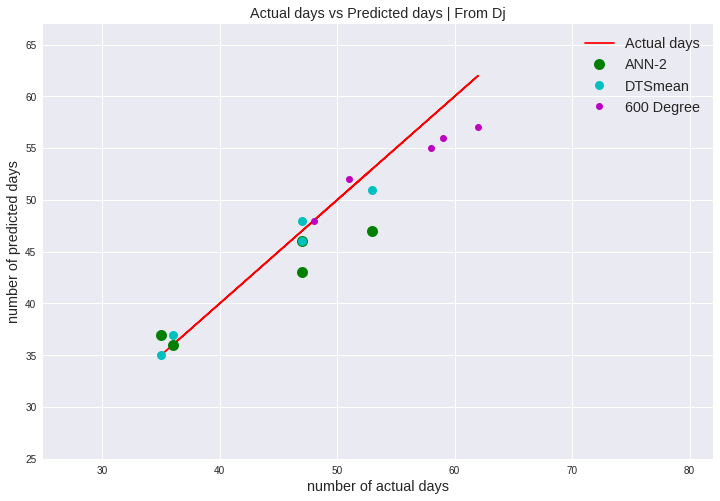

In [60]:
plt.plot(number_of_days_actual_test, number_of_days_actual_test, color='r', label='Actual days') 
plt.plot(number_of_days_actual_test, output_value, 'o', color='g', markersize=11, label='ANN-2') 
plt.plot(number_of_days_actual_test, number_of_days_DTSmean_test, 'o', markersize=9, color='c', label='DTSmean') 

plt.plot(number_of_days_actual, number_of_days_actual, color='r')
plt.plot(number_of_days_actual, number_of_days_600, 'o', color='m', label='600 Degree')

plt.legend(loc='best', shadow=True, fontsize='large')
#plt.text(20, 15, 'DTSj mean', color='k')

plt.xlabel('number of actual days', fontsize='large')
plt.ylabel('number of predicted days', fontsize='large')

plt.title("Actual days vs Predicted days | From Dj", fontsize='large')
plt.xlim(25, np.max(number_of_days_actual) + 20)
plt.ylim(25, np.max(number_of_days_600)+10)

plt.rcParams['figure.figsize'] = [12, 8]
plt.show()


***
## 4. Trends of the Sakura blooming phenomenon 

### Problem 4-1:
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

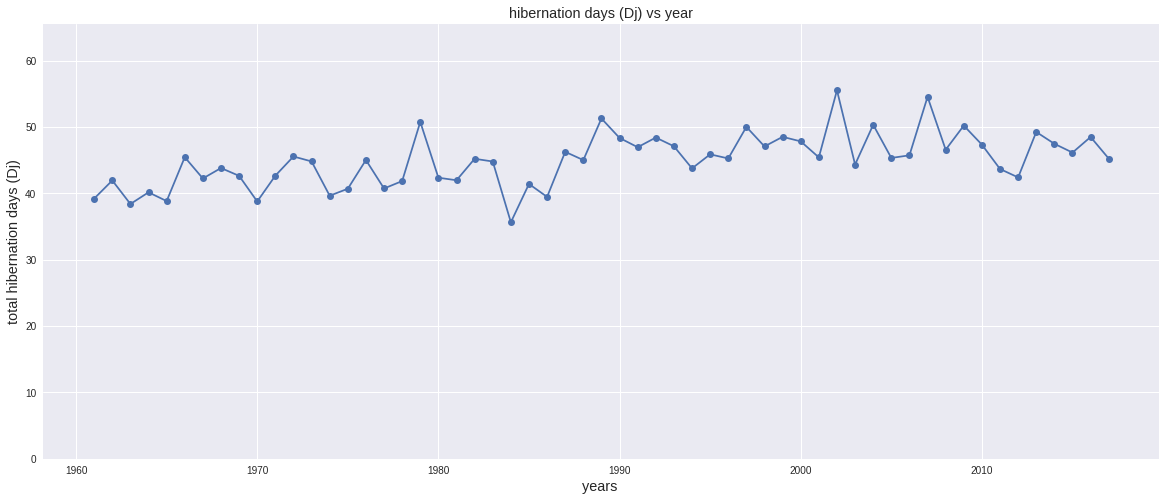

In [26]:

plt.plot(all_years, Dj_each_years, 'o', linestyle='-')

plt.xlabel('years ', fontsize='large')
plt.ylabel('total hibernation days (Dj)', fontsize='large')

plt.title("hibernation days (Dj) vs year", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(Dj_each_years)+10)

plt.rcParams['figure.figsize'] = [20, 8]
plt.show()



In [66]:

Dj_each_years_indexes_4 = []
number_of_days_actual_all = []
actual_bloomDay_indexes_all = []

for i in range(len(all_years)):
  Dj_each_years[i] = round(Dj_each_years[i])
  Dj_each_years_indexes_4.append( int(jan_1_indexes_years_dic[all_years[i]] + Dj_each_years[i] - 1) )
  
  actual_bloomDay_indexes_all.append(int(all_data_df[(all_data_df.bloom==1) & (all_data_df.year==all_years[i])].index[0]))
  
  number_of_days_actual_all.append((actual_bloomDay_indexes_all[i] - Dj_each_years_indexes_4[i] + 1))
  
print('number_of_days_actual_all :', number_of_days_actual_all)


number_of_days_actual_all : [53, 50, 54, 54, 54, 35, 48, 46, 54, 59, 47, 43, 46, 53, 48, 38, 41, 49, 32, 50, 44, 38, 46, 67, 53, 55, 37, 49, 29, 32, 43, 37, 37, 47, 45, 47, 31, 40, 35, 43, 38, 20, 43, 29, 46, 35, 25, 36, 31, 35, 44, 50, 27, 38, 37, 34, 36]


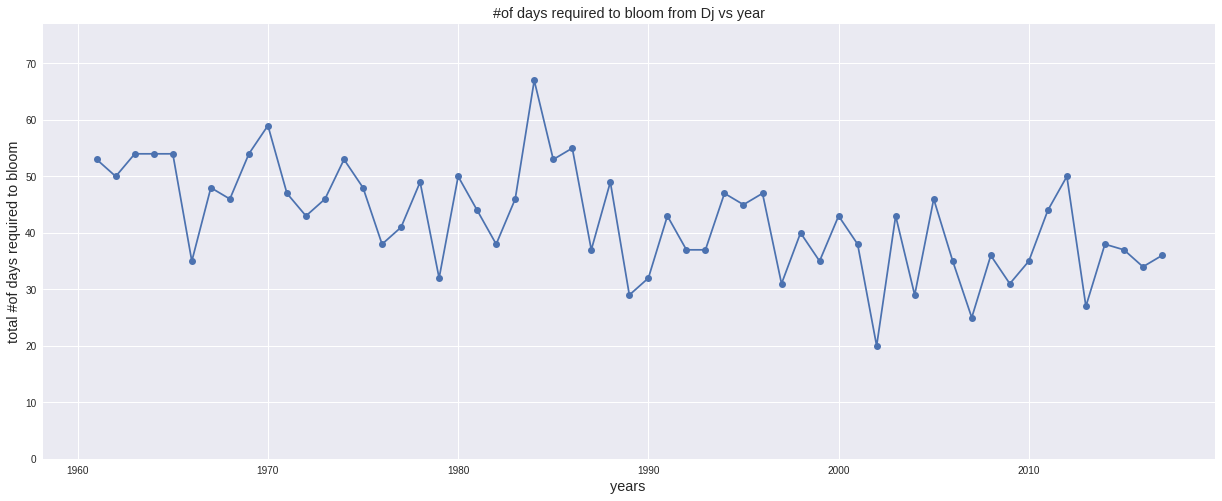

In [65]:

plt.plot(all_years, number_of_days_actual_all, 'o', linestyle='-')

plt.xlabel('years ', fontsize='large')
plt.ylabel('total #of days required to bloom', fontsize='large')

plt.title("#of days required to bloom from Dj vs year", fontsize='large')
#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(number_of_days_actual_all)+10)

plt.rcParams['figure.figsize'] = [21, 8]
plt.show()


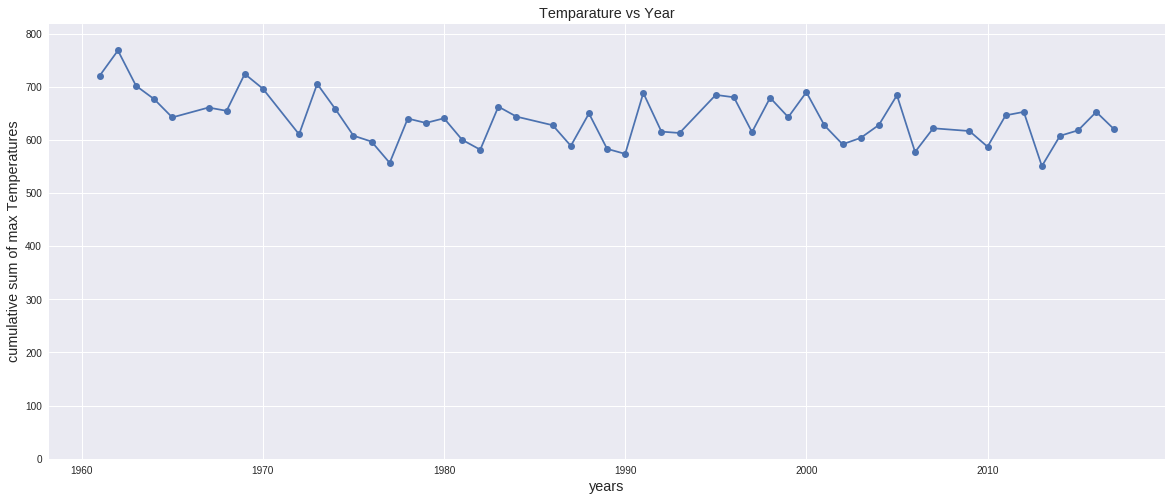

In [71]:

plt.plot(train_years, c_sum_of_maxTemps, 'o', linestyle='-')
#plt.plot(train_years, c_sum_of_maxTemps, 'o', linestyle=':' ) #color='r'

plt.xlabel('years', fontsize='large')
plt.ylabel('cumulative sum of max Temperatures', fontsize='large')

plt.title("Temparature vs Year", fontsize='large')

#plt.xlim(0, len(loss_list) + 10)
plt.ylim(0, np.max(c_sum_of_maxTemps)+50)

plt.rcParams['figure.figsize'] = [20, 8]
plt.show()


- From the hibernation $(Dj)$ curve we see that total hibernatin days is a little bit upward curve. From that we can assume that total hibernation days will increase in upcoming years. 
- On the other hand total temperature of daily max temperature from february-1 to actual bloom day is going low in the graph, we see. From that we can assume that required total temperature for chemical reaction  to reach $DTSmean$ from $Dj$ is going low. 
- And total days from $Dj$ to $BDj$ is also going lower. 
- So we can sum up from these information that if hibernation phase lasts long in a particular year then required number of days for sakura blooming from $Dj$ would be fewer and vice-versa.   
And also this can be say in this way that if hibernation phase lasts long in a particular year then for sakura blooming that year will take fewer temperature for chemical reaction.
-  So we see that $Dj$ and $BDj$ are related with temperature, and temperature is related with global warming. So it can be said that sakura blooming also related with global warming and we can assume that in upcoming years hibernation will be more longer and from hibernation to $BDj$ will be earlier. 